In [6]:
import pandas as pd
import re
from dotenv import load_dotenv
import os
import asyncio
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from langchain_openai import AzureChatOpenAI
import time
from pydantic import BaseModel, Field
from langchain_core.prompts import ChatPromptTemplate
from IPython.display import Image, display

In [2]:
bbaw_eg = pd.read_csv('../Data/bbaw_egyptian.csv')
thesaurus_earlier = pd.read_csv('../Data/thesaurus_earlier.csv')
thesaurus_late = pd.read_csv('../Data/thesaurus_late.csv')

In [3]:
load_dotenv()

True

# BBAW

In [3]:
# https://huggingface.co/datasets/phiwi/bbaw_egyptian

In [4]:
bbaw_eg.isna().sum()

transcription        7
translation         21
hieroglyphs      65233
dtype: int64

Extract only how have hieroglyphics "we might use the unlabled again"

In [5]:
# select rows where hieroglyphs is not null
bbaw_eg_w_hieroglyphs = bbaw_eg[bbaw_eg['hieroglyphs'].notna()].reset_index(drop=True)

# select rows where hieroglyphs is null
bbaw_eg_wo_hieroglyphs = bbaw_eg[bbaw_eg['hieroglyphs'].isna()].reset_index(drop=True)

Cleaning

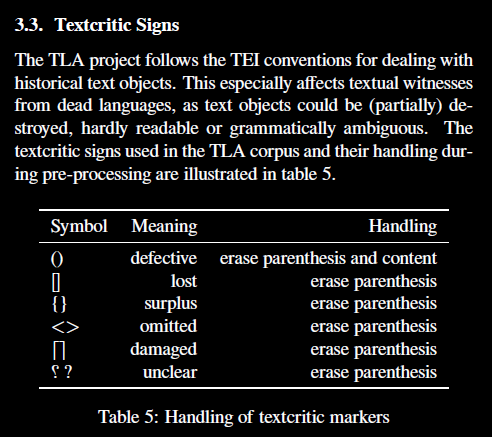

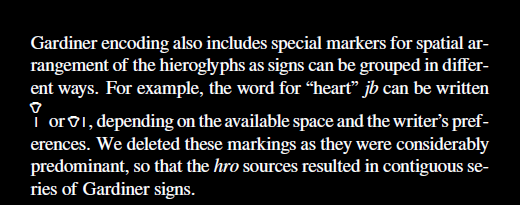

In [ ]:
# show image from path in this notebook
display(Image("../images/bbaw_pre.png"))
display(Image("../images/bbaw_pre1.png"))

In [7]:
def clean_hieroglyphs(hiero_str):
    if not isinstance(hiero_str, str):
        return ""

    # 1) Remove parentheses and their contents: ()
    hiero_str = re.sub(r'\(.*?\)', '', hiero_str)

    # 2) Remove text-critical brackets ([], {}, ⌈⌉, ⸢⸣)
    hiero_str = re.sub(r'[\[\]\{\}⌈⌉⸢⸣]', ' ', hiero_str)

    # 3) Remove unclear marker '?'
    hiero_str = hiero_str.replace('?', '')

    # 4) Remove spatial / layout operators: -, :, *, &, /, =
    hiero_str = re.sub(r'[-*:\/=&]', ' ', hiero_str)

    # 5) Normalize spaces
    hiero_str = ' '.join(hiero_str.split())

    return hiero_str


In [8]:
def clean_translation(text):
    """
    Clean the translation field (German 'de') following
    the preprocessing in Wiesenbach & Riezler (2019).
    - Remove defective passages in (...) including contents
    - Strip textcritic brackets [] {} <> ⌈⌉ ⸢⸣ but keep their contents
    - Remove unclear markers ? and ؟
    - Normalize whitespace
    """
    if not isinstance(text, str):
        return ""

    # 1) Remove () and everything inside (defective)
    text = re.sub(r'\(.*?\)', '', text)

    # 2) Remove bracket characters, but keep inner text
    #    [] {} <> ⌈⌉ ⸢⸣
    text = re.sub(r'[\[\]\{\}<>⌈⌉⸢⸣]', '', text)

    # 3) Remove "unclear" markers ? and Arabic ؟
    text = re.sub(r'[؟?]', '', text)

    # 4) Normalize whitespace
    text = ' '.join(text.split())

    return text

In [9]:
def clean_transcription(trans: str) -> str:
    """
    Clean the transcription field (trans) following
    the preprocessing in Wiesenbach & Riezler (2019).

    - Remove defective passages in (...) including contents
    - Strip textcritic brackets [] {} <> ⌈⌉ ⸢⸣ but keep their contents
    - Remove unclear markers ? and Arabic ؟
    - Normalize whitespace
    """
    if not isinstance(trans, str):
        return ""

    # 1) Remove () and everything inside (defective, plus comments)
    trans = re.sub(r'\(.*?\)', '', trans)

    # 2) Remove bracket characters, but keep inner text
    #    [] {} <> ⌈⌉ ⸢⸣ if present
    trans = re.sub(r'[\[\]\{\}<>⌈⌉⸢⸣]', '', trans)

    # 3) Remove "unclear" markers ? and Arabic ؟
    trans = re.sub(r'[؟?]', '', trans)

    # 4) Normalize whitespace
    trans = ' '.join(trans.split())

    return trans


In [10]:
bbaw_eg_w_hieroglyphs['hieroglyphs'] = bbaw_eg_w_hieroglyphs['hieroglyphs'].apply(clean_hieroglyphs)
bbaw_eg_w_hieroglyphs['translation'] = bbaw_eg_w_hieroglyphs['translation'].apply(clean_translation)
bbaw_eg_w_hieroglyphs['transcription'] = bbaw_eg_w_hieroglyphs['transcription'].apply(clean_transcription)

In [ ]:
bbaw_eg_w_hieroglyphs.to_csv('../Cleaned_Data/bbaw_egyptian_w_hieroglyphs.csv', index=False)

In [12]:
bbaw_eg_wo_hieroglyphs.drop(columns=['hieroglyphs'], inplace=True)

In [ ]:
bbaw_eg_wo_hieroglyphs['transcription'] = bbaw_eg_wo_hieroglyphs['transcription'].apply(clean_transcription)
bbaw_eg_wo_hieroglyphs['translation'] = bbaw_eg_wo_hieroglyphs['translation'].apply(clean_translation)
bbaw_eg_wo_hieroglyphs.to_csv('../Cleaned_Data/bbaw_egyptian_wo_hieroglyphs.csv', index=False)

In [14]:
bbaw_eg_w_hieroglyphs

,transcription,translation,hieroglyphs
0,"jr,j-pꜥ,t ḥꜣ,tj-ꜥ ḫtm,w-bj,tj smr-wꜥ,tj jm,j-r...","Hereditary noble and prince, royal seal-bearer...",D21 Q3 D36 F4 D36 L2 X1 S19 S29 U23 T21 X1 G17...
1,"j ꜥnḫ.w.pl tp,j.pl-tꜣ swꜣ.t =sn ḥr jz pn m-ḫdi...","O living ones, who are upon the earth, who sha...",M17 A26 S34 Aa1 G43 A1 Z3 h N17 N23 A1 Z2B S29...
2,"jnk mḥ-jb-n-nswt m ḥw,t-nṯr rʾ-Nḫn m pr Stj,t ...","I was a trusted one of the king in the temple,...",W24 V31 V22 F34 N35 M23 X1 N35 G17 R8 O6 X1 O1...
3,"ꜥq jb.pl ḥr-sꜣ mr,yt jm,j-rʾ-ꜥḥꜥ,w-wr-m-pr-nsw...","A trusted one upon the landing place, great ov...",G35 F34 F34 F34 D2 Z1 Aa17 U6 D21 M17 M17 X1 N...
4,"jw jri̯.n = jz m ḥz,t nswt sjqr.n wj ḥm =f m t...","I built a tomb through the favour of the king,...",M17 G43 D4 N35 M17 M40 O34 O1 Z1 G17 V28 W14 X...
...,...,...,...
35498,"wr⸮.pl n pḥ,tj =k",Die Großen ... werden fallen ... aufgrund dein...,G36 D21 A21 N35 F4 V31
35499,"hmhm =k mj hh nsr.t m-sꜣ ḫꜣs,t nb.t",Dein Kriegsschrei folgt wie der Gluthauch des ...,O4 G17 O4 G17 A2 Z2 V31 W19 M17 O4 O4 Q7 N35 F...
35500,"ḫꜣs,t nb.t twt.w m jb wꜥ.tj fkw =sn tꜣ =sn m-mn,t",... jedes Fremdland ist einträchtig eines einz...,N25 X1 Z1 V30 X1 X1 G43 X1 G43 Y1 Z2 Aa15 F34 ...
35501,r zj.tw ṯꜣw r fnḏ =sn jn kꜣ =k,... damit durch deinen Ka Atem für ihre Nasen ...,D21 O35 Z4A D54 X1 G43 P5 G43 Z2 D21 D20 O34 N...


# thesaurus earlier

In [15]:
# https://huggingface.co/datasets/thesaurus-linguae-aegyptiae/tla-Earlier_Egyptian_original-v18-premium

In [ ]:
thesaurus_earlier = pd.read_csv('../Data/thesaurus_earlier.csv')

In [17]:
thesaurus_earlier.head()

,hieroglyphs,transliteration,lemmatization,UPOS,glossing,translation,dateNotBefore,dateNotAfter
0,𓐩𓏌𓀜 𓂧 𓂋 𓋴,nḏ (w)di̯ r =s,90880|nḏ 51510|wdi̯ 91901|r 10090|=s,VERB VERB ADP PRON,V\tam.pass V\tam.pass PREP:stpr -3sg.f,"(es) werde zerrieben, (es) werde darauf gelegt.",-1580,-1539
1,𓂜 𓍿𓅱 𓇋𓅓 𓋴𓈖,n ṯw ꞽm =sn,78890|n 174900|ṯw 400007|m 10100|=sn,PART PRON ADP PRON,PTCL =2sg.m PREP:stpr -3pl,Du gehörst nicht zu ihnen.,-2278,-2184
2,<g>M12B</g> 𓅓 𓏐𓏒 𓏊 𓃾𓏒 𓅿 𓈖 𓄪 𓄓𓈙𓈖𓂝𓎩𓏨 𓇋𓏠𓈖𓅓𓄂𓏏 𓐙𓊤︂,ḫꜣ m tʾ ḥnq.t kꜣ(.PL) ꜣpd(.PL) n ꞽmꜣḫ ꞽm.ꞽ-rʾ-...,113110|ḫꜣ 400082|m 168810|tʾ 110300|ḥnq.t 1629...,NOUN ADP NOUN NOUN NOUN NOUN ADP NOUN NOUN PRO...,N.m PREP N.m N.f N.m:pl N.m:pl PREP N.m TITL R...,"Tausend an Brot, Bier, Rindern und Geflügel fü...",-1878,-1843
3,𓊢𓂝,ꜥḥꜥ,40110|ꜥḥꜥ,VERB,V\imp.sg,Steh auf!,-2278,-2184
4,𓊨𓁹 𓍹𓃹𓈖𓇋𓋴𓍺 𓌇 𓈖 𓎡 𓁹𓏏𓏤𓅃 𓇋𓂝𓎺 𓈖 𓎡 𓋴 𓇋𓂋 𓂋 𓎡,(w)sꞽr wnꞽs m n =k ꞽr.t-ḥr.w ꞽꜥb n =k s(ꞽ) ꞽr ...,49461|Wsꞽr 800001|Wnꞽs 67780|mꞽ 400055|n 10110...,NOUN PROPN VERB ADP PRON NOUN VERB ADP PRON PR...,TITL ROYLN V\imp.sg PREP:stpr -2sg.m N.f V\imp...,"Osiris Unas, nimm dir das Horusauge und stecke...",-2375,-2345


In [18]:
thesaurus_earlier = thesaurus_earlier[['hieroglyphs','translation']]

In [19]:
translation_thesaurus_earlier = thesaurus_earlier['translation'].tolist()
translation_bbaw_eg_w_hieroglyphs = bbaw_eg_w_hieroglyphs['translation'].tolist()

# Finding common translations between the two datasets

# remove non-string entries
translation_thesaurus_earlier = [t for t in translation_thesaurus_earlier if isinstance(t, str)]
translation_bbaw_eg_w_hieroglyphs = [t for t in translation_bbaw_eg_w_hieroglyphs if isinstance(t, str)]

# remove non-alphabetic characters
translation_thesaurus_earlier = [re.sub(r'[^a-zA-Z\s]', '', t) for t in translation_thesaurus_earlier]
translation_bbaw_eg_w_hieroglyphs = [re.sub(r'[^a-zA-Z\s]', '', t) for t in translation_bbaw_eg_w_hieroglyphs]

# strip leading and trailing whitespace
translation_thesaurus_earlier = [t.strip() for t in translation_thesaurus_earlier]
translation_bbaw_eg_w_hieroglyphs = [t.strip() for t in translation_bbaw_eg_w_hieroglyphs]

# remove empty strings
translation_thesaurus_earlier = [t for t in translation_thesaurus_earlier if t]
translation_bbaw_eg_w_hieroglyphs = [t for t in translation_bbaw_eg_w_hieroglyphs if t]

# normalize to lowercase
translation_thesaurus_earlier = [t.lower() for t in translation_thesaurus_earlier]
translation_bbaw_eg_w_hieroglyphs = [t.lower() for t in translation_bbaw_eg_w_hieroglyphs]

# find common translations
common_translations = set(translation_thesaurus_earlier).intersection(set(translation_bbaw_eg_w_hieroglyphs))
len(common_translations)

2758

# thesaurus late

In [20]:
# https://huggingface.co/datasets/thesaurus-linguae-aegyptiae/tla-late_egyptian-v19-premium

In [ ]:
thesaurus_late = pd.read_csv('../Data/thesaurus_late.csv')

In [22]:
thesaurus_late.head()

,hieroglyphs,transliteration,lemmatization,UPOS,glossing,translation,dateNotBefore,dateNotAfter
0,𓇋𓅱 𓅯𓄿 𓇯𓅺𓏏𓏭𓅂𓀜𓀀𓏥𓈖𓉻𓉐𓉐𓅆𓋹𓍑𓋴 𓁷<g>Ff101</g>𓏤 𓈝𓅓𓏏𓂻 𓂋 𓌸...,ꞽw pꜣ ḥr.ꞽ-rḫt.ꞽ.w.PL-n-pr-ꜥꜣ-ꜥnḫ-wḏꜣ-snb ḥr š...,851513|ꞽw 58770|pꜣ 854607|ḥr.ꞽ-rḫt.ꞽw-n-pr-ꜥꜣ-...,PART PRON NOUN ADP VERB ADP NOUN PART NOUN PRO...,PTCL art:m.sg N.m PREP V\inf PREP N.f PTCL N:s...,Dann ging der Leiter der Wäscher Pharaos - LHG...,-1202,-1198
1,𓇋𓏲 𓆑 𓁷𓏤 𓂞𓏏 𓈖 𓆑 𓉐𓏤 𓎛𓈖𓂝 𓄿𓎛𓏏𓈇𓏥 𓅓𓏇𓏏𓏏𓏛 𓇋𓄿𓏲𓏏𓊑𓄛𓏥 𓐍𓏏𓏛𓏥...,ꞽw ⸗f ḥr ḏi̯.t n ⸗f pr ḥnꜥ ꜣḥ.t.PL m-mꞽ.tt ꞽꜣ....,851513|ꞽw 10050|⸗f 107529|ḥr 96700|rḏi̯ 400055...,PART PRON ADP VERB ADP PRON NOUN ADP NOUN ADV ...,AUX:stpr -3sg.m PREP V\inf PREP:stpr -3sg.m N....,"Dann gab er ihm ein Haus und Felder, gleicherm...",-1279,-1213
2,𓅯𓄿𓇋𓇋 𓀀 𓂀 𓅯𓄿𓇋𓇋 𓋴𓏏 𓅧𓈎𓏲𓂻 𓈖𓃀𓏲𓈖𓏥𓂋𓏤𓈐𓂻,pꜣy ⸗ꞽ wḏꜣ pꜣy ⸗st ꜥqw n-bw~n~rʾ,550021|pꜣy⸗ 10030|⸗ꞽ 52100|wḏꜣ 550021|pꜣy⸗ 100...,PRON PRON NOUN PRON PRON VERB ADV,art.poss:m.sg -1sg N.m art.poss:m.sg -3sg.f V\...,Ihr Eintreten von außen (sorgt für) mein Wohlb...,-1149,-1077
3,𓃹𓈖𓇋𓈖 𓊃 𓁷<g>Ff100</g>𓏤 𓈝𓅓𓏏<g>Ff100</g>𓂻 𓂋 𓆓𓂧 𓈖 ...,wn.ꞽn ⸗s ḥr šmi̯.t r ḏd n pꜣ-rꜥ-ḥr.w-ꜣḫ.tꞽ.DU,650007|wn.ꞽn 10090|⸗s 107529|ḥr 852485|šmi̯ 91...,PART PRON ADP VERB ADP VERB ADP PROPN,AUX:stpr -3sg.f PREP V\inf PREP V\inf PREP DIVN,"Da ging sie, um Re-Harachte zu sagen:",-1149,-1077
4,𓂜𓈖 𓇋𓏲 𓀀 𓂋 𓂞𓏏 𓅷𓄿𓇋𓇋𓂷𓂡 𓈖 𓀀 𓅂𓄿𓇋𓇋 𓀀 𓎟,nn ꞽw ⸗ꞽ r ḏi̯.t ṯꜣy n ⸗ꞽ pꜣy ⸗ꞽ nb,84550|nn 851514|ꞽw 10030|⸗ꞽ 91907|r 550028|rḏi...,PART PART PRON ADP VERB VERB ADP PRON PRON PRO...,PTCL AUX:stpr -1sg PREP V\inf V\tam.act PREP:s...,"Ich werde keinen Anlass geben, dass mein Herr ...",-1202,-1198


In [23]:
thesaurus_late = thesaurus_late[['hieroglyphs','translation']]

In [24]:
# find common translations between thesaurus_late and bbaw_eg_w_hieroglyphs

translation_thesaurus_late = thesaurus_late['translation'].tolist()
translation_bbaw_eg_w_hieroglyphs = bbaw_eg_w_hieroglyphs['translation'].tolist()

# remove non-string entries
translation_thesaurus_late = [t for t in translation_thesaurus_late if isinstance(t, str)]
translation_bbaw_eg_w_hieroglyphs = [t for t in translation_bbaw_eg_w_hieroglyphs if isinstance(t, str)]

# remove non-alphabetic characters
translation_thesaurus_late = [re.sub(r'[^a-zA-Z\s]', '', t) for t in translation_thesaurus_late]
translation_bbaw_eg_w_hieroglyphs = [re.sub(r'[^a-zA-Z\s]', '', t) for t in translation_bbaw_eg_w_hieroglyphs]

# strip leading and trailing whitespace
translation_thesaurus_late = [t.strip() for t in translation_thesaurus_late]
translation_bbaw_eg_w_hieroglyphs = [t.strip() for t in translation_bbaw_eg_w_hieroglyphs]

# remove empty strings
translation_thesaurus_late = [t for t in translation_thesaurus_late if t]
translation_bbaw_eg_w_hieroglyphs = [t for t in translation_bbaw_eg_w_hieroglyphs if t]

# normalize to lowercase
translation_thesaurus_late = [t.lower() for t in translation_thesaurus_late]
translation_bbaw_eg_w_hieroglyphs = [t.lower() for t in translation_bbaw_eg_w_hieroglyphs]

# find common translations
common_translations_late = set(translation_thesaurus_late).intersection(set(translation_bbaw_eg_w_hieroglyphs))
len(common_translations_late)

545

# Translating bbaw_eg to English

In [29]:
llm = AzureChatOpenAI(
    azure_deployment=os.getenv("GPT_OSS_DEPLOYMENT_NAME"),
    openai_api_version=os.getenv("AZURE_OPENAI_API_VERSION"),
    azure_endpoint=os.getenv("AZURE_OPENAI_ENDPOINT"),
    api_key=os.getenv("AZURE_OPENAI_API_KEY"),
    timeout=40,
    max_retries=1,
)

In [30]:
system_prompt = """### ROLE
You are a headless data processing engine, not a chatbot. You translate historical text (originally hieroglyphs) from German/Mixed-Language to English.
Might contain some severity
### INPUT DATA
The input will be a string that:
1. May be German, English, or a mix of both.

### PROCESSING INSTRUCTIONS
1. TRANSLATION: 
   - Translate all German parts to English. Preserve existing English parts exactly.
   - If input is all English, return the english input as it is.
   - don't include any intro or outro. only return the translation or the english text given
2. CLEANING: 
   - REMOVE any double spaces caused by removing dots.
3. OUTPUT: Return the result in natural text.

### FORMATTING RULES (STRICT)
- OUTPUT MUST BE NATURAL LANGUAGE TEXT.
- REMOVE ANY DOTS AT END OR BEGINNING IF THERE IS.
"""

user_prompt = """INPUT_TEXT:
"{german}"
"""

In [ ]:
# prompt = ChatPromptTemplate.from_messages([
#     ("system", system_prompt),
#     ("user", user_prompt)
# ])

In [ ]:
# MAX_CONCURRENCY = 64   
# MAX_ATTEMPTS = 1       


# async def translate_text(i, german_text, semaphore):
#     """Translate a single text, with retries, keep index i."""
#     async with semaphore:
#         for attempt in range(1, MAX_ATTEMPTS + 1):
#             try:
#                 formatted_prompt = prompt.format_messages(german=german_text)
#                 response = await llm.ainvoke(formatted_prompt)
#                 translation = response.content
#                 print(f"Row {i} translated (attempt {attempt})")
#                 return {"index": i, "ok": True, "translation": translation, "error": None}

#             except Exception as e:
#                 print(f"Error on row {i} (attempt {attempt}): {e}")
#                 if attempt == MAX_ATTEMPTS:
#                     # Give up on this row, but keep index so order can be restored
#                     return {"index": i, "ok": False, "translation": None, "error": str(e)}
#                 # Exponential backoff before next retry
#                 wait_s = 2 ** attempt
#                 await asyncio.sleep(wait_s)

In [ ]:
# async def translate_to_english():
#     """Translate bbaw_eg_w_hieroglyphs['translation'] into 'translation_en'."""
#     global bbaw_eg_w_hieroglyphs

#     semaphore = asyncio.Semaphore(MAX_CONCURRENCY)

#     texts = bbaw_eg_w_hieroglyphs["translation"].fillna("").astype(str).tolist()
#     n = len(texts)
#     print(f"Translating {n} rows with max concurrency = {MAX_CONCURRENCY} ...")

#     tasks = [
#         asyncio.create_task(translate_text(i, text, semaphore))
#         for i, text in enumerate(texts)
#     ]

#     results = await asyncio.gather(*tasks)

#     results.sort(key=lambda r: r["index"])

#     translations = []
#     failed_indices = []

#     for r in results:
#         if r["ok"] and r["translation"] is not None:
#             translations.append(r["translation"])
#         else:
#             # Keep alignment: put empty string (or original text) for failed rows
#             translations.append("")
#             failed_indices.append((r["index"], r["error"]))

#     # Attach new column to your df
#     bbaw_eg_w_hieroglyphs["translation_en"] = translations

#     print(f"Total rows:   {n}")
#     print(f"Failed rows:  {len(failed_indices)}")
#     if failed_indices:
#         print("Example failed rows (index, error):", failed_indices[:10])

#     return failed_indices

In [ ]:
# failed = await translate_to_english()

Translating 35503 rows with max concurrency = 64 ...
Error on row 34 (attempt 1): Error code: 400 - {'error': {'message': "The response was filtered due to the prompt triggering Azure OpenAI's content management policy. Please modify your prompt and retry. To learn more about our content filtering policies please read our documentation: https://go.microsoft.com/fwlink/?linkid=2198766", 'type': None, 'param': 'prompt', 'code': 'content_filter', 'status': 400, 'innererror': {'code': 'ResponsibleAIPolicyViolation', 'content_filter_result': {'hate': {'filtered': False, 'severity': 'safe'}, 'jailbreak': {'filtered': False, 'detected': False}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': True, 'severity': 'medium'}}}}}
Row 8 translated (attempt 1)
Row 17 translated (attempt 1)
Row 48 translated (attempt 1)
Row 20 translated (attempt 1)
Row 5 translated (attempt 1)
Row 46 translated (attempt 1)
Row 57 transla

In [ ]:
# len(failed)

2588

In [ ]:
# in translation_en if row is empty or only spaces, make it NaN
# bbaw_eg_w_hieroglyphs['translation_en'] = bbaw_eg_w_hieroglyphs['translation_en'].apply(lambda x: x if isinstance(x, str) and x.strip() else None)
# bbaw_eg_w_hieroglyphs['translation'] = bbaw_eg_w_hieroglyphs['translation'].apply(lambda x: x if isinstance(x, str) and x.strip() else None)

In [ ]:
# bbaw_eg_w_hieroglyphs.to_csv('../Cleaned_Data/bbaw_egyptian_w_hieroglyphs_translated.csv', index=False)

In [ ]:
# bbaw_eg_w_hieroglyphs

,transcription,translation,hieroglyphs,translation_en
0,"jr,j-pꜥ,t ḥꜣ,tj-ꜥ ḫtm,w-bj,tj smr-wꜥ,tj jm,j-r...","Hereditary noble and prince, royal seal-bearer...",D21 Q3 D36 F4 D36 L2 X1 S19 S29 U23 T21 X1 G17...,"Hereditary noble and prince, royal seal-bearer..."
1,"j ꜥnḫ.w.pl tp,j.pl-tꜣ swꜣ.t =sn ḥr jz pn m-ḫdi...","O living ones, who are upon the earth, who sha...",M17 A26 S34 Aa1 G43 A1 Z3 h N17 N23 A1 Z2B S29...,"O living ones, who are upon the earth, who sha..."
2,"jnk mḥ-jb-n-nswt m ḥw,t-nṯr rʾ-Nḫn m pr Stj,t ...","I was a trusted one of the king in the temple,...",W24 V31 V22 F34 N35 M23 X1 N35 G17 R8 O6 X1 O1...,"I was a trusted one of the king in the temple,..."
3,"ꜥq jb.pl ḥr-sꜣ mr,yt jm,j-rʾ-ꜥḥꜥ,w-wr-m-pr-nsw...","A trusted one upon the landing place, great ov...",G35 F34 F34 F34 D2 Z1 Aa17 U6 D21 M17 M17 X1 N...,"A trusted one upon the landing place, great ov..."
4,"jw jri̯.n = jz m ḥz,t nswt sjqr.n wj ḥm =f m t...","I built a tomb through the favour of the king,...",M17 G43 D4 N35 M17 M40 O34 O1 Z1 G17 V28 W14 X...,"I built a tomb through the favour of the king,..."
...,...,...,...,...
35498,"wr⸮.pl n pḥ,tj =k",Die Großen ... werden fallen ... aufgrund dein...,G36 D21 A21 N35 F4 V31,The great ones will fall because of your strength
35499,"hmhm =k mj hh nsr.t m-sꜣ ḫꜣs,t nb.t",Dein Kriegsschrei folgt wie der Gluthauch des ...,O4 G17 O4 G17 A2 Z2 V31 W19 M17 O4 O4 Q7 N35 F...,Your war cry follows like the glowing breath o...
35500,"ḫꜣs,t nb.t twt.w m jb wꜥ.tj fkw =sn tꜣ =sn m-mn,t",... jedes Fremdland ist einträchtig eines einz...,N25 X1 Z1 V30 X1 X1 G43 X1 G43 Y1 Z2 Aa15 F34 ...,"Every foreign land is united in a single wish,..."
35501,r zj.tw ṯꜣw r fnḏ =sn jn kꜣ =k,... damit durch deinen Ka Atem für ihre Nasen ...,D21 O35 Z4A D54 X1 G43 P5 G43 Z2 D21 D20 O34 N...,


# Analysis

In [5]:
bbaw_eg_w_hieroglyphs = pd.read_csv('../Cleaned_Data/bbaw_egyptian_w_hieroglyphs_translated.csv')

In [6]:
bbaw_eg_w_hieroglyphs.dropna(subset=['translation_en','hieroglyphs'], inplace=True)

In [7]:
bbaw_eg_w_hieroglyphs.isna().sum()

transcription     0
translation       0
hieroglyphs       0
translation_en    0
dtype: int64

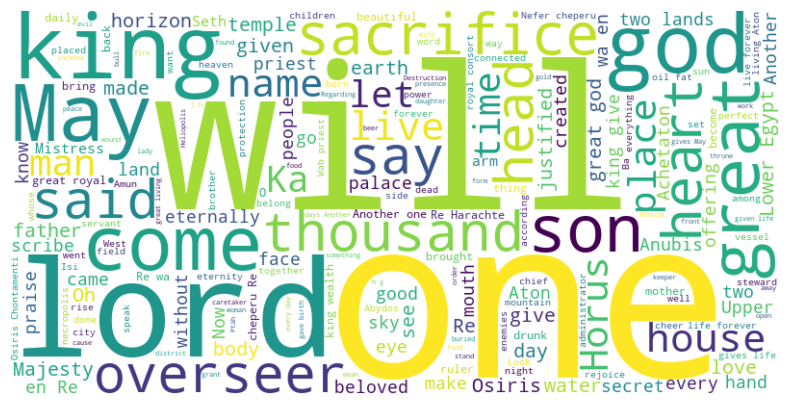

In [ ]:
# plot image cloud for english 
text = ' '.join(bbaw_eg_w_hieroglyphs['translation_en'].dropna().tolist())
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

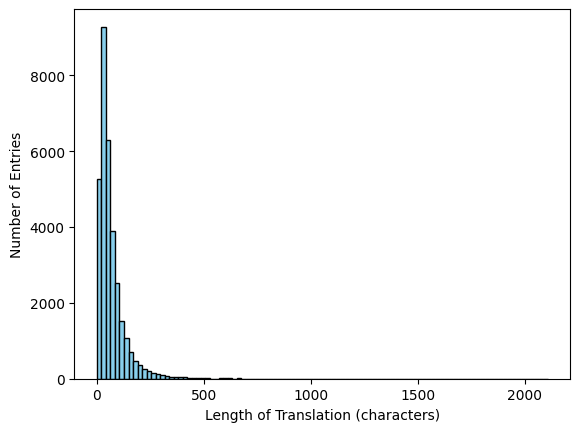

In [9]:
# plot length distribution of translations in english
lengths = bbaw_eg_w_hieroglyphs['translation_en'].dropna().apply(len)
plt.hist(lengths, bins=100, color='skyblue', edgecolor='black')
plt.xlabel('Length of Translation (characters)')
plt.ylabel('Number of Entries')
plt.show()

In [10]:
# length of translations in english statistics
lengths = bbaw_eg_w_hieroglyphs['translation_en'].dropna().apply(len)
print(f"Min length: {lengths.min()}")
print(f"Max length: {lengths.max()}")
print(f"Mean length: {lengths.mean()}")
print(f"Median length: {lengths.median()}")
print(f"Standard Deviation: {lengths.std()}")

Min length: 1
Max length: 2107
Mean length: 68.25195378344418
Median length: 48.0
Standard Deviation: 70.52871826972823


In [12]:
bbaw_eg_w_hieroglyphs.head()

,transcription,translation,hieroglyphs,translation_en
0,"jr,j-pꜥ,t ḥꜣ,tj-ꜥ ḫtm,w-bj,tj smr-wꜥ,tj jm,j-r...","Hereditary noble and prince, royal seal-bearer...",D21 Q3 D36 F4 D36 L2 X1 S19 S29 U23 T21 X1 G17...,"Hereditary noble and prince, royal seal-bearer..."
1,"j ꜥnḫ.w.pl tp,j.pl-tꜣ swꜣ.t =sn ḥr jz pn m-ḫdi...","O living ones, who are upon the earth, who sha...",M17 A26 S34 Aa1 G43 A1 Z3 h N17 N23 A1 Z2B S29...,"O living ones, who are upon the earth, who sha..."
2,"jnk mḥ-jb-n-nswt m ḥw,t-nṯr rʾ-Nḫn m pr Stj,t ...","I was a trusted one of the king in the temple,...",W24 V31 V22 F34 N35 M23 X1 N35 G17 R8 O6 X1 O1...,"I was a trusted one of the king in the temple,..."
3,"ꜥq jb.pl ḥr-sꜣ mr,yt jm,j-rʾ-ꜥḥꜥ,w-wr-m-pr-nsw...","A trusted one upon the landing place, great ov...",G35 F34 F34 F34 D2 Z1 Aa17 U6 D21 M17 M17 X1 N...,"A trusted one upon the landing place, great ov..."
4,"jw jri̯.n = jz m ḥz,t nswt sjqr.n wj ḥm =f m t...","I built a tomb through the favour of the king,...",M17 G43 D4 N35 M17 M40 O34 O1 Z1 G17 V28 W14 X...,"I built a tomb through the favour of the king,..."
